In [ ]:
import numpy as np
import src.graphinglib as gl
import scipy as sp
from scipy.signal import convolve, deconvolve
from astropy.modeling import models

from src.hdu.cubes.cube import Cube
from src.spectrums.spectrum import Spectrum

In [ ]:
calib = Cube.load("data/orion/calibration/calibration_cube.fits")
nii_cube = Cube.load("data/orion/data_cubes/nii_1.fits")

calib_spec = calib[:,250,250]
nii_spec = nii_cube[:,250,250]

### Early tests

In [ ]:
deconvolved_spec = deconvolve(nii_spec.data, calib_spec.data)[1]

deconvolution_fig = gl.SmartFigure(3, 1, elements=[calib_spec.plot, nii_spec.plot,
                                     gl.Curve(nii_spec.x_values, deconvolved_spec, label="Deconvolved [NII] spectrum")])
deconvolution_fig[0][0].label = "Calibration spectrum"
deconvolution_fig[0][0].color = "red"
deconvolution_fig[1][0].label = "[NII] spectrum"
deconvolution_fig[2][0].color = "green"
deconvolution_fig.show()

In [ ]:
fake_nii_spec = Spectrum((models.Gaussian1D(38, 13, 1.7) + models.Gaussian1D(70, 33, 2))(nii_spec.x_values), None)
convoluted_spec = convolve(fake_nii_spec.data, calib_spec.data, mode="same")

convolution_fig = gl.SmartFigure(3, 1, elements=[plot := calib_spec.plot, fake_nii_spec.plot,
                            gl.Curve(nii_spec.x_values, convoluted_spec, label="Convolved artificial [NII] spectrum")])
plot.label = "Calibration spectrum"
plot.color = "red"
convolution_fig[1][0].label = "Artificial [NII] gaussian spectrum"
convolution_fig[2][0].color = "green"
convolution_fig.show()

### New tests

In [ ]:
resampled_calib = sp.signal.resample(calib_spec.data, nii_spec.data.size)
# gl.SmartFigure(elements=[gl.Curve(np.arange(48) + 1, resampled_calib), gl.Curve(np.linspace(1, 48, 192), calib_spec.data)]).show()
normalized_calib = resampled_calib / np.sum(resampled_calib)
normalized_calib = np.roll(normalized_calib, nii_spec.data.size // 2 - np.argmax(normalized_calib))
# gl.SmartFigure(elements=[gl.Curve(np.arange(48) + 1, normalized_calib)]).show()

def wiener_deconvolve(signal, kernel, K=0.01):
    S = np.fft.fft(signal)
    H = np.fft.fft(kernel)
    H_conj = np.conj(H)
    return np.real(np.fft.ifft((H_conj / (H_conj * H + K)) * S))

n = 2 * len(nii_spec.data)  # Or next power of 2 for efficiency
signal = np.pad(nii_spec.data, (0, n - len(nii_spec.data)))
kernel = np.pad(normalized_calib, (0, n - len(normalized_calib)))
deconvolved_spec = wiener_deconvolve(signal, kernel)
deconvolved_spec = wiener_deconvolve(nii_spec.data, normalized_calib)
deconvolved_curve = gl.Curve(np.arange(nii_spec.data.size) + 1, deconvolved_spec, label="Deconvolved")
g_spec = gl.FitFromGaussian(nii_spec.plot, "Spectrum fit", [75, 32, 5])
g_deconv = gl.FitFromGaussian(deconvolved_curve, "Deconvolved fit", [115, 25, 5])
gl.SmartFigure(elements=[nii_spec.plot, deconvolved_curve]).show()
# gl.SmartFigure(elements=[nii_spec.plot, deconvolved_curve, g_spec, g_deconv]).show()

### Test convolution

In [ ]:
# Create a compound spectrum: two Gaussians + noise
x = nii_spec.x_values
gauss1 = models.Gaussian1D(amplitude=40, mean=15, stddev=1.5)
gauss2 = models.Gaussian1D(amplitude=60, mean=32, stddev=2.5)
noise = np.random.normal(0, 1, size=x.size)
compound_data = gauss1(x) + gauss2(x) + noise

compound_spec = Spectrum(compound_data, None)

# Convolve with calib_spec
convolved_compound = convolve(compound_spec.data, calib_spec.data, mode="same")

# Plot the result
gl.SmartFigure(elements=[
    compound_spec.plot,
    calib_spec.plot,
    # gl.Curve(x, convolved_compound, label="Convolved Compound Spectrum")
]).show()

In [ ]:
import numpy as np
import src.graphinglib as gl
from scipy.signal import fftconvolve
from scipy.special import voigt_profile

# --- Define channel axis ---
x = np.linspace(1, 48, 48)

# --- 1. TRUE SIGNAL: Two Gaussians ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

true_signal = (
    gaussian(x, amp=1.0, mu=12, sigma=1.5) +   # Main emission
    gaussian(x, amp=0.5, mu=31, sigma=1.0)     # Companion line
)

# --- 2. INSTRUMENTAL FUNCTION (approximated Gaussian) ---
instrumental_sigma = 2.5
# instrumental_kernel = gaussian(x, 1.0, mu=24, sigma=instrumental_sigma)
instrumental_kernel = voigt_profile(x - 24, 1.5, instrumental_sigma)
instrumental_kernel /= np.sum(instrumental_kernel)  # Normalize

# --- 3. Convolve (observed spectrum) ---
observed_signal = fftconvolve(true_signal, instrumental_kernel, mode='same')

# --- 4. Wrap into graphinglib Curves ---
true_curve = gl.Curve(x, true_signal, label="True Signal (2 Gaussians)", color="black", line_style="--")
instr_curve = gl.Curve(x, instrumental_kernel * true_signal.max(), label="Instrumental Profile", color="cyan", line_style=":")
observed_curve = gl.Curve(x, observed_signal, label="Observed (Convolved)", color="red")


g_fit = gl.FitFromGaussian(observed_curve, "Observed Fit", [0.15, 31, 4], color="lime")

# --- 5. Plot ---
sf = gl.SmartFigure(
    elements=[true_curve, instr_curve, observed_curve],#, g_fit],
    title="Fabry-Perot Convolution",
).show()

In [ ]:
from skimage.restoration import richardson_lucy

# Ensure normalization of kernel
kernel = instrumental_kernel / np.sum(instrumental_kernel)
recovered_signal = richardson_lucy(observed_signal, kernel, num_iter=70)

rec_curve = gl.Curve(x, recovered_signal, label="Recovered Signal", color="green")

sf.copy().add_elements(rec_curve).show()

### Philippe test

In [ ]:
from scipy.special import voigt_profile

np.random.seed(2)

# ========== PARAMETERS ==========
N = 48
x = np.arange(N)
center = N // 2
sigma_input = 3.5
sigma_lsf = 2.20
noise_amplitude = 2e-3  # 1e-2
iterations = 100

# ========== SYNTHETIC SPECTRUMS CREATION ==========
# raw_input = np.exp(-0.5 * ((x - (center + 5)) / sigma_input) ** 2)
raw_input = voigt_profile(x - (center + 5.2), 1.5, sigma_input)
raw_input += noise_amplitude * np.random.normal(size=N)
# raw_input = np.array(nii_spec.data)

# raw_lsf = np.exp(-0.5 * ((x - (center - 4)) / sigma_lsf) ** 2)
raw_lsf = voigt_profile(x - (center - 3.3), 1.5, sigma_lsf)
# raw_lsf = np.array(calib_spec.bin(4).data)

fig = gl.SmartFigure(
    1,
    2,
    elements=[gl.Curve(x, raw_input, label="Input Signal"), gl.Curve(x, raw_lsf, label="LSF", color="red")],
    size=(8, 4),
    general_legend=True,
    legend_loc="outside lower center",
    legend_cols=2,
).show()

In [ ]:
# ========== CENTERING AND NORMALIZATION ==========
def recenter_profile(profile, center=center):
    x_vals = np.arange(len(profile))
    centroid = np.argmax(profile)  # np.sum(profile * x_vals) / np.sum(profile)
    shift = int(round(center - centroid))
    profile_shifted = np.roll(profile, shift)
    return profile_shifted

def normalize_area(signal):
    return signal / np.sum(signal)

input_signal = recenter_profile(raw_input)
input_signal = normalize_area(input_signal)

lsf = recenter_profile(raw_lsf)
lsf = normalize_area(lsf)

fig.copy_with(
    elements=[
        gl.Curve(x, input_signal, label="Centered Input Signal"),
        gl.Curve(x, lsf, label="Centered LSF", color="red")
    ],
).show()

In [ ]:
# ========== DECONVOLUTION ==========
def richardson_lucy(image, psf, iterations=30, eps=1e-6):
    image = image.astype(np.float64)
    estimate = np.full_like(image, 0.5)
    psf_mirror = psf[::-1]
    for _ in range(iterations):
        conv = convolve(estimate, psf, mode='same')
        conv = np.clip(conv, eps, None)
        ratio = image / conv
        correction = convolve(ratio, psf_mirror, mode='same')
        estimate *= correction
        estimate = np.clip(estimate, 0, 1e3)
    return estimate


output_signal = richardson_lucy(input_signal, lsf, iterations)
output_signal = normalize_area(output_signal)
output_signal = recenter_profile(output_signal)
output_signal = normalize_area(output_signal)

# ========== RECONVOLUTION ==========
reconvolved = convolve(output_signal, lsf, mode='same')
reconvolved = normalize_area(reconvolved)
reconvolved = recenter_profile(reconvolved)

# ========== RESIDUE ==========
residual = input_signal - reconvolved

# ========== DISPERSION MEASUREMENT ==========
def measure_sigma(signal):
    centroid = np.sum(signal * x) / np.sum(signal)
    var = np.sum(signal * (x - centroid) ** 2) / np.sum(signal)
    return np.sqrt(var)

sigma_in_meas = measure_sigma(input_signal)
sigma_out_meas = measure_sigma(output_signal)
sigma_lsf_meas = measure_sigma(lsf)
sigma_check = np.sqrt(sigma_out_meas**2 + sigma_lsf_meas**2)

# ========== PLOT NORMALIZATION ==========
def normalize_for_plot(signal):
    max_abs = np.max(np.abs(signal))
    return signal / max_abs if max_abs != 0 else signal

# ========== CENTERING FOR TRACING X ==========
x_centered = x - center


In [ ]:
all_signals = np.array([
    normalize_for_plot(input_signal),
    normalize_for_plot(lsf),
    normalize_for_plot(output_signal),
    normalize_for_plot(reconvolved)
])
mu_res = np.mean(residual)
std_res = np.std(residual)

fig1 = gl.SmartFigure(
    y_label="Normalized Amplitude",
    y_lim=(-0.05, np.max(1.05 * all_signals)),
    elements=[
        gl.Curve(x_centered, all_signals[0], label=f"Input (σ={sigma_in_meas:.2f})"),
        gl.Curve(x_centered, all_signals[1], label=f"LSF (σ={sigma_lsf_meas:.2f})"),
        gl.Curve(x_centered, all_signals[2], label=f"Deconvolved (σ={sigma_out_meas:.2f})"),
        gl.Curve(x_centered, all_signals[3], line_style="--", label="Reconvolved"),
        gl.Vlines(0, colors="k", line_styles=":", label="Center"),
    ],
    reference_labels=False,
    legend_loc="upper right",
    title=f"Deconvolution – Verification: σ_in ≈ √(σ_out² + σ_lsf²) = {sigma_check:.2f} (LSF σ={sigma_lsf_meas:.2f})",
).set_ticks(x_tick_spacing=4).set_tick_params(
    draw_bottom_labels=False, draw_top_ticks=True, draw_top_labels=True, draw_right_labels=True, draw_right_ticks=True,
)

fig2 = gl.SmartFigure(
    x_label="Centered Channel",
    y_label="Residue",
    elements=[
        gl.Curve(x_centered, residual, color='gray'),
        gl.Hlines(0, colors='k', line_styles='--'),
        gl.Text(0.55, 1.1, f"Residue: μ = {mu_res:.3e}, σ = {std_res:.3e}", relative_to="figure"),
    ],
    reference_labels=False,
).set_ticks(x_tick_spacing=4)

global_fig = gl.SmartFigure(
    2,
    1,
    size=(12, 6),
    height_ratios=[3, 1],
    share_x=True,
    height_padding=0,
    elements=[fig1, fig2],
).show()

#### Test with cubes

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.


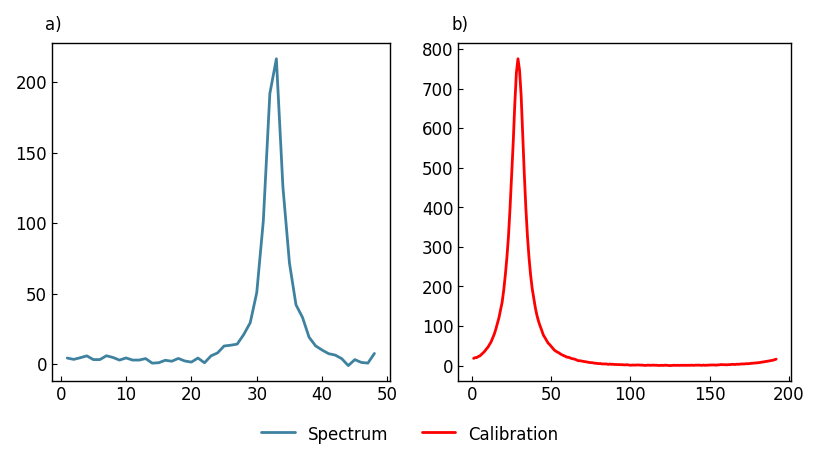

In [5]:
calib = Cube.load("data/orion/calibration/calibration_cube.fits")
nii_cube = Cube.load("data/orion/data_cubes/nii_1.fits")
np.random.seed(42)

coords = (386, 277)
calib_spec = calib[:, *coords]
spec = nii_cube[:, *coords]
spec.data[:20] = np.random.normal(np.median(spec.data[:20]), 1.5, size=20)  # remove the second peak
center = 25

fig = gl.SmartFigure(
    num_cols=2,
    size=(8, 4),
    elements=[
        gl.Curve(spec.x_values, spec.data, label="Spectrum"),
        gl.Curve(calib_spec.x_values, calib_spec.data, label="Calibration", color="red"),
    ],
    general_legend=True,
    legend_loc="outside lower center",
    legend_cols=2,
).show()

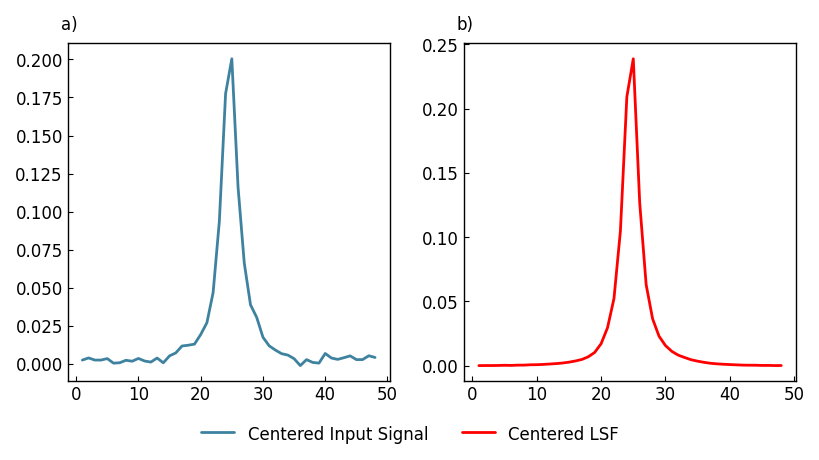

In [6]:
def recenter_profile(profile):
    centroid = 1 + np.argmax(profile)  # Use argmax for centering
    shift = int(round(center - centroid))
    profile_shifted = np.roll(profile, shift)
    return profile_shifted

def normalize_area(signal):
    return signal / np.sum(signal)

input_signal = recenter_profile(spec.data)
input_signal = normalize_area(input_signal)

lsf = recenter_profile(calib_spec.data.bin([4]))
lsf = normalize_area(lsf)

fig.copy_with(
    elements=[
        gl.Curve(spec.x_values, input_signal, label="Centered Input Signal"),
        gl.Curve(spec.x_values, lsf, label="Centered LSF", color="red")
    ],
).show()

In [7]:
# ========== DECONVOLUTION ==========
def richardson_lucy(image, psf, iterations=200, eps=1e-6):
    image = image.astype(np.float64)
    estimate = np.full_like(image, 0.5)
    psf_mirror = psf[::-1]
    for _ in range(iterations):
        conv = convolve(estimate, psf, mode='same')
        conv = np.clip(conv, eps, None)
        ratio = image / conv
        correction = convolve(ratio, psf_mirror, mode='same')
        estimate *= correction
        estimate = np.clip(estimate, 0, 1e3)
    return estimate


output_signal = richardson_lucy(input_signal, lsf)
output_signal = normalize_area(output_signal)
output_signal = recenter_profile(output_signal)
# output_signal = normalize_area(output_signal)

# ========== RECONVOLUTION ==========
reconvolved = convolve(output_signal, lsf, mode='same')
reconvolved = normalize_area(reconvolved)
reconvolved = recenter_profile(reconvolved)

# ========== RESIDUE ==========
residual = input_signal - reconvolved

# ========== DISPERSION MEASUREMENT ==========
def measure_sigma(signal):
    centroid = np.sum(signal * spec.x_values) / np.sum(signal)
    var = np.sum(signal * (spec.x_values - centroid) ** 2) / np.sum(signal)
    return np.sqrt(var)

sigma_in_meas = measure_sigma(input_signal)
sigma_out_meas = measure_sigma(output_signal)
sigma_lsf_meas = measure_sigma(lsf)
sigma_check = np.sqrt(sigma_out_meas**2 + sigma_lsf_meas**2)

# ========== PLOT NORMALIZATION ==========
def normalize_for_plot(signal):
    max_abs = np.max(np.abs(signal))
    return signal / max_abs if max_abs != 0 else signal

# ========== CENTERING FOR TRACING X ==========
x_centered = spec.x_values - center

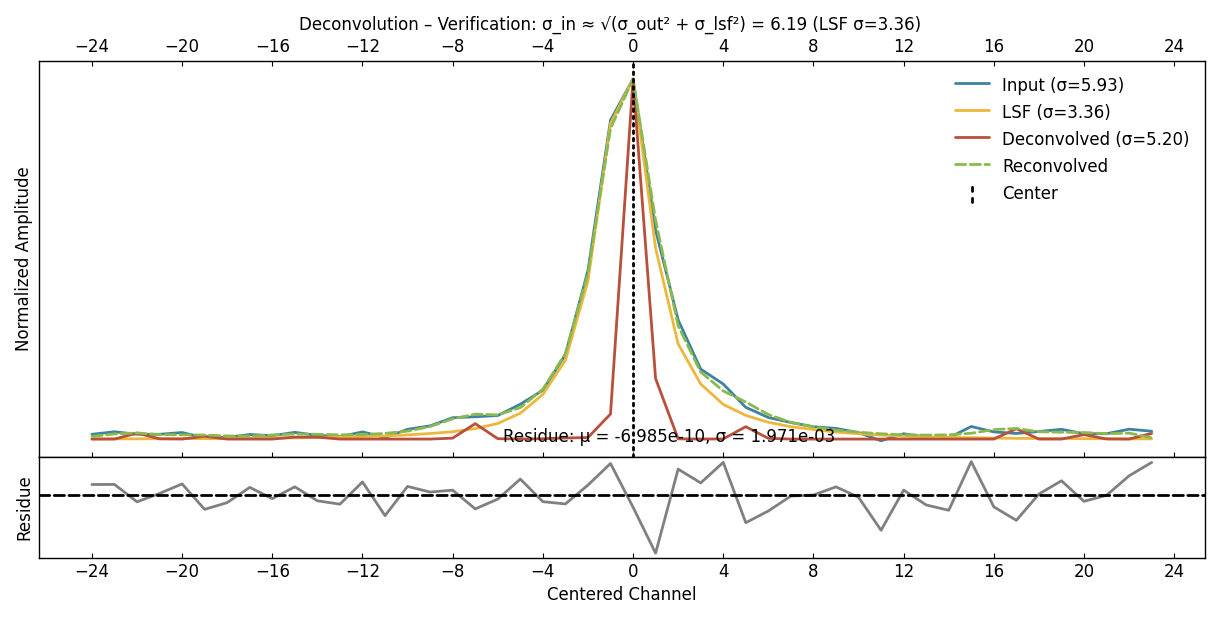

In [8]:
all_signals = np.array([
    normalize_for_plot(input_signal),
    normalize_for_plot(lsf),
    normalize_for_plot(output_signal),
    normalize_for_plot(reconvolved)
])
mu_res = np.mean(residual)
std_res = np.std(residual)

fig1 = gl.SmartFigure(
    y_label="Normalized Amplitude",
    y_lim=(-0.05, np.max(1.05 * all_signals)),
    elements=[
        gl.Curve(x_centered, all_signals[0], label=f"Input (σ={sigma_in_meas:.2f})"),
        gl.Curve(x_centered, all_signals[1], label=f"LSF (σ={sigma_lsf_meas:.2f})"),
        gl.Curve(x_centered, all_signals[2], label=f"Deconvolved (σ={sigma_out_meas:.2f})"),
        gl.Curve(x_centered, all_signals[3], line_style="--", label="Reconvolved"),
        gl.Vlines(0, colors="k", line_styles=":", label="Center"),
    ],
    reference_labels=False,
    legend_loc="upper right",
    title=f"Deconvolution – Verification: σ_in ≈ √(σ_out² + σ_lsf²) = {sigma_check:.2f} (LSF σ={sigma_lsf_meas:.2f})",
).set_ticks(x_tick_spacing=4).set_tick_params(
    draw_bottom_labels=False, draw_top_ticks=True, draw_top_labels=True, draw_right_labels=True, draw_right_ticks=True,
)

fig2 = gl.SmartFigure(
    x_label="Centered Channel",
    y_label="Residue",
    elements=[
        gl.Curve(x_centered, residual, color='gray'),
        gl.Hlines(0, colors='k', line_styles='--'),
        gl.Text(0.55, 1.1, f"Residue: μ = {mu_res:.3e}, σ = {std_res:.3e}", relative_to="figure"),
    ],
    reference_labels=False,
).set_ticks(x_tick_spacing=4)

global_fig = gl.SmartFigure(
    2,
    1,
    size=(12, 6),
    height_ratios=[3, 1],
    share_x=True,
    height_padding=0,
    elements=[fig1.copy_with(remove_y_ticks=True), fig2.copy_with(remove_y_ticks=True)],
).show()

#### Test with code

In [2]:
from src.tools.deconvolution import *
from src.hdu.cubes.cube import Cube


calib = Cube.load("data/orion/calibration/calibration_cube.fits").bin([4, 1, 1])
nii_cube = Cube.load("data/orion/data_cubes/nii_1.fits")
# gl.SmartFigure(elements=[nii_cube[:,250,250].plot]).show()
# nii_cube.data[:20, :, :] = np.random.normal(np.median(nii_cube.data[:20, :, :]), 1.5, size=nii_cube.data[:20, :, :].shape)  # remove the second peak

x_values = nii_cube[:,0,0].x_values
calib_spec = calib.data[:, 350, 260][:, None, None]
nii_spec = nii_cube.data[:, 350, 260][:, None, None]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue.


In [ ]:
output = deconvolve_cube(nii_spec, calib_spec, 100)

reconvolved = convolve(output[:,0,0], calib_spec[:,0,0], mode="same")
reconvolved = reconvolved / reconvolved.sum()
reconvolved = np.roll(reconvolved, x_values.size // 2 - reconvolved.argmax())

print(get_deconvolution_error(nii_spec, output, calib_spec))

gl.SmartFigure(
    elements=[
        gl.Curve(x_values,
                 np.roll(nii_spec[:,0,0] / nii_spec[:,0,0].max(), x_values.size // 2 - nii_spec[:,0,0].argmax()),
                 "Original Spectrum"),
        gl.Curve(x_values, output[:,0,0] / output[:,0,0].max(), "Deconvolved Spectrum"),
        gl.Curve(x_values, reconvolved / reconvolved.max(), "Reconvolved Spectrum"),
        # gl.Curve(x_values, calib_spec[:,0,0] / calib_spec[:,0,0].max(), "Calibration Spectrum"),
    ],
).show()
fig = gl.SmartFigure(elements=[c := gl.Scatter(x_values, output[:,0,0])], size=(8, 4), show_legend=False)
fig.add_elements(gl.FitFromGaussian(c, "Deconvolved Fit", [0.6, 25, 1])).show()

TypeError: deconvolve_cube() missing 2 required positional arguments: 'lsf_centroids' and 'n_iterations'

In [4]:
gl.Curve(x_values, nii_spec[:,0,0]).to_desmos(to_clipboard=True)

'[(1.,1.41),(2.,1.68),(3.,-7.37\\cdot10^{-2}),(4.,-3.41\\cdot10^{-1}),(5.,1.17),(6.,2.15),(7.,4.93),(8.,4.41),(9.,4.93),(1.\\cdot10^{1},7.35),(1.1\\cdot10^{1},2.21\\cdot10^{1}),(1.2\\cdot10^{1},3.91\\cdot10^{1}),(1.3\\cdot10^{1},4.2\\cdot10^{1}),(1.4\\cdot10^{1},2.9\\cdot10^{1}),(1.5\\cdot10^{1},1.75\\cdot10^{1}),(1.6\\cdot10^{1},1.19\\cdot10^{1}),(1.7\\cdot10^{1},8.73),(1.8\\cdot10^{1},2.15),(1.9\\cdot10^{1},3.71),(2.\\cdot10^{1},8.8\\cdot10^{-1}),(2.1\\cdot10^{1},6.41),(2.2\\cdot10^{1},7.66),(2.3\\cdot10^{1},7.95),(2.4\\cdot10^{1},5.39),(2.5\\cdot10^{1},1.04\\cdot10^{1}),(2.6\\cdot10^{1},1.29\\cdot10^{1}),(2.7\\cdot10^{1},1.19\\cdot10^{1}),(2.8\\cdot10^{1},2.26\\cdot10^{1}),(2.9\\cdot10^{1},3.33\\cdot10^{1}),(3.\\cdot10^{1},5.07\\cdot10^{1}),(3.1\\cdot10^{1},1.\\cdot10^{2}),(3.2\\cdot10^{1},1.81\\cdot10^{2}),(3.3\\cdot10^{1},1.69\\cdot10^{2}),(3.4\\cdot10^{1},1.09\\cdot10^{2}),(3.5\\cdot10^{1},6.77\\cdot10^{1}),(3.6\\cdot10^{1},3.32\\cdot10^{1}),(3.7\\cdot10^{1},2.5\\cdot10^{1}),(3.8